In [1]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from poisson1d import stiffnessMatrix1DFD
from scipy.sparse import eye
from scipy.sparse.linalg import spsolve

In [15]:
zmax = 6
dz = 0.5
z = np.arange(0., zmax, dz)

In [16]:
a = 1.5e-7
A, b = stiffnessMatrix1DFD(z, a, f=0)
print(A.shape, len(z))

(12, 12) 12


In [14]:
A

array([[ 1.5e-05, -1.5e-05,  0.0e+00, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [-1.5e-05,  3.0e-05, -1.5e-05, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [ 0.0e+00, -1.5e-05,  3.0e-05, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       ...,
       [ 0.0e+00,  0.0e+00,  0.0e+00, ...,  3.0e-05, -1.5e-05,  0.0e+00],
       [ 0.0e+00,  0.0e+00,  0.0e+00, ..., -1.5e-05,  3.0e-05, -1.5e-05],
       [ 0.0e+00,  0.0e+00,  0.0e+00, ...,  0.0e+00, -1.5e-05,  1.5e-05]])

In [5]:
def laplace(u, x, a=1):
    dadx = a * np.diff(u) / np.diff(x)    
    return np.diff(dadx) / (x[2:]-x[:-2]) * 2

In [6]:
def upperBoundary(t, T0, dT, tP):
    return np.sin(t/tP*2*np.pi)*dT + T0

In [7]:
# some definitions independent on method
T0 = 11
dT = 9
day = 60 * 60 * 24
year = 365 * day

0.3887999999999999


C:\Users\Thomas Guenther\AppData\Local\Temp\ipykernel_17880\1329073855.py:8: RuntimeWarning: overflow encountered in multiply
  T += A.dot(T) * dt
C:\Users\Thomas Guenther\AppData\Local\Temp\ipykernel_17880\1329073855.py:8: RuntimeWarning: overflow encountered in add
  T += A.dot(T) * dt


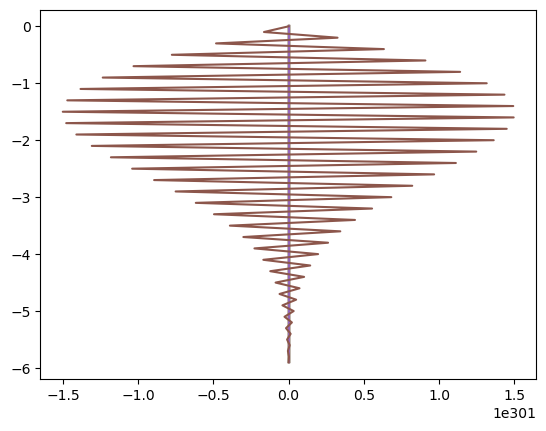

In [8]:
dt = day * 0.3  # 0.3
print(dt/dz**2*a)
T = np.ones_like(z) * T0
t = 0
for i in range(int(year*0.75//dt)):  # run for 2 years
    t += dt
    # T[1:-1] += laplace(T, z, a)
    T += A.dot(T) * dt
    T[0] = upperBoundary(t, T0, dT, year)
    T[-1] = T0
    # print(t//day, T[0])
    if i % 50 == 0:
        plt.plot(T, -z)

## Implicit method

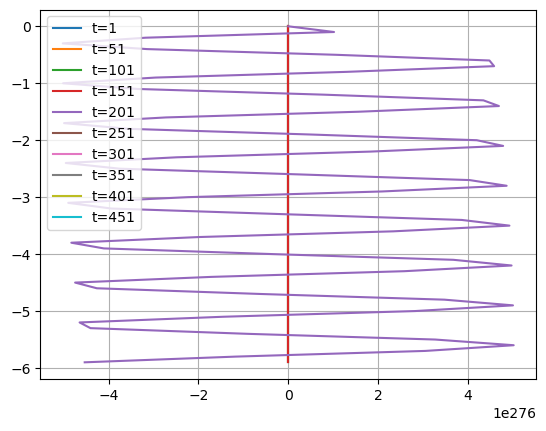

In [9]:
dt = day * 1
M = np.eye(len(z)) / dt
# M[0, 0] = 0
# M[-1, -1] = 0
MmA = M - A
T = np.ones_like(z) * T0
t = 0
for i in range(500*day//dt):  # run for 2 years
    t += dt
    rhs = M.dot(T)
    # rhs[0] = -upperBoundary(t, T0, dT, year)
    T = np.linalg.solve(MmA, rhs)
    T[0] = upperBoundary(t, T0, dT, year)
    if i % 50 == 0:
        plt.plot(T, -z, label="t={:d}".format(t//day))
    
plt.legend()
plt.grid()

## Crank-Nicholson method

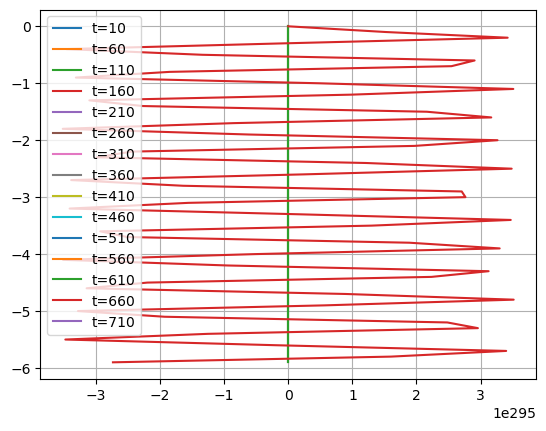

In [10]:
dt = day * 1
ZMmA = 2*M - A
ZMpA = 2*M + A
T = np.ones_like(z) * T0
t = 0
nt = 365*2*day//dt
TT = np.zeros([nt, len(T)])
for i in range(nt):  # run for 2 years
    rhs = ZMpA.dot(T)
    # rhs[0] = upperBoundary(t, T0, dT, year)
    t += dt
    T = np.linalg.solve(ZMmA, rhs)
    T[0] = upperBoundary(t, T0, dT, year)
    TT[i] = T
    if i % 50 == 9:
        plt.plot(T, -z, label="t={:d}".format(t//day))
    
plt.legend()
plt.grid()

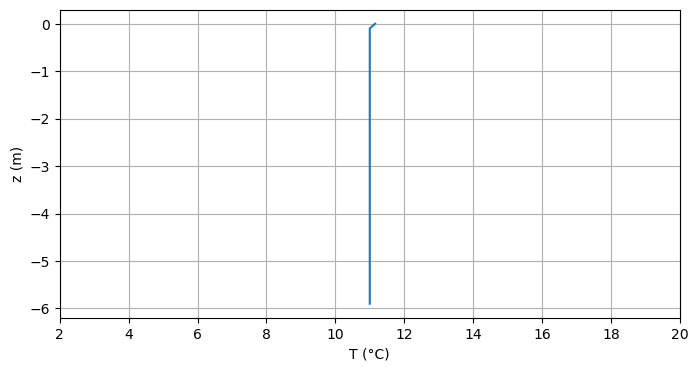

In [11]:
import matplotlib.animation as animation
from IPython.display import HTML
fig, ax = plt.subplots(figsize=(8, 4))
line, = ax.plot(TT[0], -z) # , label="t={:d}".format(t//day)) 
ax.set_xlim(2, 20)
ax.set_xlabel("T (°C)")
ax.set_ylabel("z (m)")
ax.grid()

In [12]:
def animate(i):
    line.set_xdata(TT[i])
    return line,

ani = animation.FuncAnimation(fig, animate, blit=True, 
                              interval=20, frames=len(TT)) # save_count=22)
HTML(ani.to_html5_video())

In [13]:
ani.save("temperature.mp4")